# Text classifiers
This notebook tests models that use only text word features. 


The models are transformer-encoder based. There was attached classification head to encoder. The concept is to use pretrained encoder and fine-tune it on classification task. It is also possible to first fine-tune encoder on general language task such as Mask Language Modeling and then adding layers responsible for classification and fine-tuning model on classification model. The second idea allows to make encoder more reliable on data domain that will be used in final task - classification.

In [1]:
from torch import nn
import torch

In [2]:
# imports
from config import SDK_PATH, DATA_PATH, WORD_EMB_PATH, CACHE_PATH
import sys

if SDK_PATH is None:
    print("SDK path is not specified! Please specify first in constants/paths.py")
    exit(0)
else:
    sys.path.append(SDK_PATH)

# import mmsdk
import os
import re
import numpy as np
from mmsdk import mmdatasdk as md
from subprocess import check_call, CalledProcessError

import pandas as pd
from sklearn import metrics
import transformers
# from transformers import BertTokenizer, BertModel, BertConfig # this could be imported later, before model declaration
import torch
from torch.utils.data import Dataset, DataLoader #, RandomSampler, SequentialSampler

## #Define model

In [3]:
# # define model 

# seed = 10
# transformers.set_seed(seed)

# # checkpoint = 'bert-base-uncased' # 
# checkpoint = 'google-bert/bert-base-uncased'
# # checkpoint = 'MatFil99/bert-base-uncased-ft-google'
# num_classes = 2
# id2label = {0: 'negative', 1: 'positive'}
# label2id = {'negative': 0, 'positive': 1}

# model = transformers.AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels = num_classes, id2label=id2label, label2id=label2id)
# tokenizer = transformers.AutoTokenizer.from_pretrained(checkpoint)

In [4]:
# # function for comparing models architecture and weights - it does not work properly
# def compareModelWeights(model_a, model_b):
#     module_a = model_a._modules
#     module_b = model_b._modules
#     if len(list(module_a.keys())) != len(list(module_b.keys())):
#         return False
#     a_modules_names = list(module_a.keys())
#     b_modules_names = list(module_b.keys())
#     for i in range(len(a_modules_names)):
#         layer_name_a = a_modules_names[i]
#         layer_name_b = b_modules_names[i]
#         if layer_name_a != layer_name_b:
#             return False
#         layer_a = module_a[layer_name_a]
#         layer_b = module_b[layer_name_b]
#         if (
#             (type(layer_a) == nn.Module) or (type(layer_b) == nn.Module) or
#             (type(layer_a) == nn.Sequential) or (type(layer_b) == nn.Sequential)
#             ):
#             if not compareModelWeights(layer_a, layer_b):
#                 return False
#         if hasattr(layer_a, 'weight') and hasattr(layer_b, 'weight'):
#             if not torch.equal(layer_a.weight.data, layer_b.weight.data):
#                 return False
#     return True

## Data preparation

In [5]:
# choose dataset
# cmumosi, cmumosei, pom
DS = 'cmumosi' # cmumosei # pom

In [3]:
def download_datasets(ds):
    DATASET_PATH = DATA_PATH + ds

    # create folders for storing the data
    if not os.path.exists(DATA_PATH):
        check_call(' '.join(['mkdir', '-p', DATA_PATH]), shell=True)

    if ds == 'cmumosi':
        DATASET = md.cmu_mosi
    elif ds == 'cmumosei':
        DATASET = md.cmu_mosei
    elif ds == 'pom':
        DATASET = md.pom
    
    try:
        md.mmdataset(DATASET.highlevel, DATASET_PATH)
    except RuntimeError:
        print("High-level features have been downloaded previously.")
    
    try:
        md.mmdataset(DATASET.raw, DATASET_PATH)
    except RuntimeError:
        print("Raw data have been downloaded previously.")
        
    try:
        md.mmdataset(DATASET.labels, DATASET_PATH)
    except RuntimeError:
        print("Labels have been downloaded previously.")

In [7]:
download_datasets()

[2024-04-06 17:40:24.348] | Error   | D:/Studia/magisterskie/Praca_magisterska/data/repo/CMU-MultimodalSDK/cmumosi\CMU_MOSI_TimestampedWordVectors.csd file already exists ...
High-level features have been downloaded previously.
[2024-04-06 17:40:24.348] | Error   | D:/Studia/magisterskie/Praca_magisterska/data/repo/CMU-MultimodalSDK/cmumosi\CMU_MOSI_TimestampedWords.csd file already exists ...
Raw data have been downloaded previously.
[2024-04-06 17:40:24.348] | Error   | D:/Studia/magisterskie/Praca_magisterska/data/repo/CMU-MultimodalSDK/cmumosi\CMU_MOSI_Opinion_Labels.csd file already exists ...
Labels have been downloaded previously.


In [5]:
# list the directory contents... let's see what features there are ; there is also another catalog with aligned features (skipped from output)
DATASET_PATH = DATA_PATH + DS

data_files = [file for file in os.listdir(DATASET_PATH) if '.csd' in file]
print('\n'.join(data_files))

NameError: name 'DS' is not defined

In [4]:
# download highlevel features, low-level (raw) data and labels for the dataset MOSI
# if the files are already present, instead of downloading it you just load it yourself.
# here we use CMU_MOSI dataset as example.

FEATURES = {
    'cmumosi': {'text_feat': 'CMU_MOSI_TimestampedWords', 'label_feat': 'CMU_MOSI_Opinion_Labels'},
    'cmumosei': {'text_feat': 'CMU_MOSEI_TimestampedWords', 'label_feat': 'CMU_MOSEI_Labels'},
    'pom': {'text_feat': 'POM_TimestampedWords', 'label_feat': 'POM_Labels'},
}

def load_dataset(ds):
    DATASET_PATH = DATA_PATH + ds
    
    text_feat = FEATURES[ds]['text_feat']
    label_feat = FEATURES[ds]['label_feat']
    
    features = [
        text_feat,
        label_feat
    ]
    
    recipe = {
        feat: DATASET_PATH + '/' + feat + '.csd' for feat in features
    }
    dataset = md.mmdataset(recipe)
    return dataset

In [57]:
# load raw text features and labels
dataset = load_dataset(ds=DS)

[2024-04-06 17:51:41.590] | Success | Computational sequence read from file D:/Studia/magisterskie/Praca_magisterska/data/repo/CMU-MultimodalSDK/cmumosei/CMU_MOSEI_TimestampedWords.csd ...
[2024-04-06 17:51:42.019] | Status  | Checking the integrity of the <words> computational sequence ...
[2024-04-06 17:51:42.019] | Status  | Checking the format of the data in <words> computational sequence ...


[2024-04-06 17:51:43.365] | Success | <words> computational sequence data in correct format.
[2024-04-06 17:51:43.365] | Status  | Checking the format of the metadata in <words> computational sequence ...
[2024-04-06 17:51:43.365] | Warning | <words> computational sequence does not have all the required metadata ... continuing 
[2024-04-06 17:51:43.366] | Success | Computational sequence read from file D:/Studia/magisterskie/Praca_magisterska/data/repo/CMU-MultimodalSDK/cmumosei/CMU_MOSEI_Labels.csd ...
[2024-04-06 17:51:43.749] | Status  | Checking the integrity of the <All Labels> computational sequence ...
[2024-04-06 17:51:43.749] | Status  | Checking the format of the data in <All Labels> computational sequence ...


[2024-04-06 17:51:44.730] | Success | <All Labels> computational sequence data in correct format.
[2024-04-06 17:51:44.730] | Status  | Checking the format of the metadata in <All Labels> computational sequence ...
[2024-04-06 17:51:44.730] | Warning | <All Labels> computational sequence does not have all the required metadata ... continuing 
[2024-04-06 17:51:44.731] | Success | Dataset initialized successfully ... 


In [13]:
dataset.keys()

dict_keys(['CMU_MOSI_TimestampedWords', 'CMU_MOSI_Opinion_Labels'])

In [17]:
text_feat = FEATURES[DS]['text_feat']
label_feat = FEATURES[DS]['label_feat']
dataset.computational_sequences[text_feat].data['03bSnISJMiM']['features'].shape

(464, 1)

In [18]:
dataset.computational_sequences[text_feat].data['03bSnISJMiM']['intervals'].shape

(464, 2)

In [19]:
dataset.computational_sequences[text_feat].metadata

{'alignment compatible': False,
 'computational sequence description': 'Word sequences for CMU-MOSI Dataset',
 'computational sequence version': 1.0,
 'contact': 'abagherz@andrew.cmu.edu',
 'creator': 'Amir Zadeh',
 'dataset bib citation': '@article{zadeh2016multimodal,title={Multimodal sentiment intensity analysis in videos: Facial gestures and verbal messages},author={Zadeh, Amir and Zellers, Rowan and Pincus, Eli and Morency, Louis-Philippe},journal={IEEE Intelligent Systems},volume={31},number={6},pages={82--88},year={2016},publisher={IEEE}}',
 'dataset name': 'CMU-MOSI',
 'dataset version': 1.0,
 'dimension names': ['word'],
 'featureset bib citation': '@article{P2FA,title={Speaker identification on the SCOTUS corpus},author={Yuan, Jiahong and Liberman, Mark},journal={Journal of the Acoustical Society of America},volume={123},number={5},pages={3878},year={2008},publisher={[New York: Acoustical Society of America]}}',
 'md5': None,
 'root name': 'words',
 'uuid': 'cf8e3281-bcec-49f

## Features exploration

In [20]:
dataset.computational_sequences[text_feat].data['03bSnISJMiM']['features'][:15].flatten()

array([b'sp', b'oh', b'sp', b'this', b'sp', b'quality', b'is', b'sp',
       b'horrible', b'sp', b'ok', b'well', b'sp', b'anyhow', b'sp'],
      dtype='|S32')

In [21]:
' '.join([item for item in dataset.computational_sequences[text_feat].data['03bSnISJMiM']['features'][:,0].astype('str') if item != 'sp'])

'oh this quality is horrible ok well anyhow um this is and i just wanted to do a review of the movie hanna coz i just watched it today with my family oh and happy easter ok anyhow hanna is about um i dont wanna give it away but this girl husband trained her whole life to fight and just be prepared for whats out there and trying to get her anyhow it was really good did they didnt really do a whole bunch of background info on why she has to fight and be prepared i mean they did a little bit of it but not a whole bunch and they i guess they live up with more and but besides that it was all over pretty good and there is like someone while someone there was a lot of action oh my god a lot of action there is sad part a lot of sad parts but it was really really awesome um well ok so hanna she goes with this family and with this family and im not gonna say why but the daughter of the family she wants to take her she wants to go on this date but in order to go on the date she need another date 

In [22]:
print(dataset.computational_sequences[text_feat].data['03bSnISJMiM']['intervals'][:5])

[[0.01247166 1.72857143]
 [1.72857143 2.11768707]
 [2.11768707 5.16077098]
 [5.16077098 5.79931973]
 [5.79931973 6.8968254 ]]


In [23]:
# show all video ids
print('Number of videos ', len(dataset[text_feat].keys()))
dataset[text_feat].keys()

Number of videos  93


dict_keys(['03bSnISJMiM', '0h-zjBukYpk', '1DmNV9C1hbY', '1iG0909rllw', '2WGyTLYerpo', '2iD-tVS8NPw', '5W7Z1C_fDaE', '6Egk_28TtTM', '6_0THN4chvY', '73jzhE8R1TQ', '7JsX8y1ysxY', '8OtFthrtaJM', '8d-gEyoeBzc', '8qrpnFRGt2A', '9J25DZhivz8', '9T9Hf74oK10', '9c67fiY0wGQ', '9qR7uwkblbs', 'Af8D0E4ZXaw', 'BI97DNYfe5I', 'BXuRRbG0Ugk', 'Bfr499ggo-0', 'BioHAh1qJAQ', 'BvYR0L6f2Ig', 'Ci-AH39fi3Y', 'Clx4VXItLTE', 'Dg_0XKD0Mf4', 'G-xst2euQUc', 'G6GlGvlkxAQ', 'GWuJjcEuzt8', 'HEsqda8_d0Q', 'I5y0__X72p0', 'Iu2PFX3z_1s', 'IumbAb8q2dM', 'Jkswaaud0hk', 'LSi-o-IrDMs', 'MLal-t_vJPM', 'Njd1F0vZSm4', 'Nzq88NnDkEk', 'OQvJTdtJ2H4', 'OtBXNcAL_lE', 'Oz06ZWiO20M', 'POKffnXeBds', 'PZ-lDQFboO8', 'QN9ZIUWUXsY', 'Qr1Ca94K55A', 'Sqr0AcuoNnk', 'TvyZBvOMOTc', 'VCslbP0mgZI', 'VbQk4H8hgr0', 'Vj1wYRQjB-o', 'W8NXH0Djyww', 'WKA5OygbEKI', 'X3j2zQgwYgE', 'ZAIRrfG22O0', 'ZUXBRvtny7o', '_dI--eQ6qVU', 'aiEXnCPZubE', 'atnd_PF-Lbs', 'bOL9jKpeJRs', 'bvLlb-M3UXU', 'c5xsKMxpXnc', 'c7UH_rxdZv4', 'cM3Yna7AavY', 'cW1FSBF59ik', 'cXypl4FnoZo',

In [24]:
# get no. segments for vid - after alignment all should have the same number of segments
vid0 = '03bSnISJMiM'

print('Number of segment for some video before alignment')
print('No. text segments: ' , len([vsegid for vsegid in dataset[text_feat].keys() if vid0 in vsegid]))

Number of segment for some video before alignment
No. text segments:  1


### Alignment

In [25]:
# align data to labels - this type alignment does not collapse features (each video segment is made up of many elements of text, video, audio)
# 464 vid0 = '03bSnISJMiM'
dataset.align(label_feat)

[2024-04-06 17:43:59.444] | Status  | Unify was called ...
[2024-04-06 17:43:59.444] | Success | Unify completed ...
[2024-04-06 17:43:59.444] | Status  | Pre-alignment based on <CMU_MOSI_Opinion_Labels> computational sequence started ...
[2024-04-06 17:43:59.541] | Status  | Pre-alignment done for <CMU_MOSI_TimestampedWords> ...
[2024-04-06 17:43:59.543] | Status  | Alignment starting ...


Aligning 03bSnISJMiM:   0%|                                                              | 0/13 [00:00<?, ? Segments/s]
                                                                                                                       
Aligning 0h-zjBukYpk:   0%|                                                              | 0/25 [00:00<?, ? Segments/s]
                                                                                                                       
Aligning 1DmNV9C1hbY:   0%|                                                              | 0/14 [00:00<?, ? Segments/s]
                                                                                                                       
Aligning 1iG0909rllw:   0%|                                                              | 0/30 [00:00<?, ? Segments/s]
                                                                                                                       
Aligning 2WGyTLYerpo:   0%|             

[2024-04-06 17:44:00.751] | Success | Alignment to <CMU_MOSI_Opinion_Labels> complete.
[2024-04-06 17:44:00.751] | Status  | Replacing dataset content with aligned computational sequences
[2024-04-06 17:44:00.751] | Success | Initialized empty <CMU_MOSI_TimestampedWords> computational sequence.
[2024-04-06 17:44:00.751] | Status  | Checking the format of the data in <CMU_MOSI_TimestampedWords> computational sequence ...


[2024-04-06 17:44:00.755] | Success | <CMU_MOSI_TimestampedWords> computational sequence data in correct format.
[2024-04-06 17:44:00.755] | Status  | Checking the format of the metadata in <CMU_MOSI_TimestampedWords> computational sequence ...
[2024-04-06 17:44:00.755] | Warning | <CMU_MOSI_TimestampedWords> computational sequence does not have all the required metadata ... continuing 
[2024-04-06 17:44:00.755] | Success | Initialized empty <CMU_MOSI_Opinion_Labels> computational sequence.
[2024-04-06 17:44:00.755] | Status  | Checking the format of the data in <CMU_MOSI_Opinion_Labels> computational sequence ...


[2024-04-06 17:44:00.759] | Success | <CMU_MOSI_Opinion_Labels> computational sequence data in correct format.
[2024-04-06 17:44:00.759] | Status  | Checking the format of the metadata in <CMU_MOSI_Opinion_Labels> computational sequence ...
[2024-04-06 17:44:00.759] | Warning | <CMU_MOSI_Opinion_Labels> computational sequence does not have all the required metadata ... continuing 


In [21]:
# show all video segments - after alignment
print('Number of segments ', len(dataset[text_feat].keys()))
dataset[text_feat].keys()

Number of segments  2198


dict_keys(['03bSnISJMiM[0]', '03bSnISJMiM[1]', '03bSnISJMiM[2]', '03bSnISJMiM[3]', '03bSnISJMiM[4]', '03bSnISJMiM[5]', '03bSnISJMiM[6]', '03bSnISJMiM[7]', '03bSnISJMiM[8]', '03bSnISJMiM[9]', '03bSnISJMiM[10]', '03bSnISJMiM[11]', '03bSnISJMiM[12]', '0h-zjBukYpk[0]', '0h-zjBukYpk[1]', '0h-zjBukYpk[2]', '0h-zjBukYpk[3]', '0h-zjBukYpk[4]', '0h-zjBukYpk[5]', '0h-zjBukYpk[6]', '0h-zjBukYpk[7]', '0h-zjBukYpk[8]', '0h-zjBukYpk[9]', '0h-zjBukYpk[10]', '0h-zjBukYpk[11]', '0h-zjBukYpk[12]', '0h-zjBukYpk[13]', '0h-zjBukYpk[14]', '0h-zjBukYpk[15]', '0h-zjBukYpk[16]', '0h-zjBukYpk[17]', '0h-zjBukYpk[18]', '0h-zjBukYpk[19]', '0h-zjBukYpk[20]', '0h-zjBukYpk[21]', '0h-zjBukYpk[22]', '0h-zjBukYpk[23]', '0h-zjBukYpk[24]', '1DmNV9C1hbY[0]', '1DmNV9C1hbY[1]', '1DmNV9C1hbY[2]', '1DmNV9C1hbY[3]', '1DmNV9C1hbY[4]', '1DmNV9C1hbY[5]', '1DmNV9C1hbY[6]', '1DmNV9C1hbY[7]', '1DmNV9C1hbY[8]', '1DmNV9C1hbY[9]', '1DmNV9C1hbY[10]', '1DmNV9C1hbY[11]', '1DmNV9C1hbY[12]', '1DmNV9C1hbY[13]', '1iG0909rllw[0]', '1iG0909rllw[

In [22]:
# get no. segments for vid - after second alignment
vid0 = '03bSnISJMiM'

print('Number of segment for some video after alignment')
print('No. text segments: ' , len([vsegid for vsegid in dataset[text_feat].keys() if vid0 in vsegid]))
print('No. label segments: ', len([vsegid for vsegid in dataset[label_feat].keys() if vid0 in vsegid]))

Number of segment for some video after alignment
No. text segments:  13
No. label segments:  13


In [23]:
# single segment text, audio, visual features' shapes
segment = '[0]'

print('Features of segment {}'.format(vid0 + segment))
print('Text features shape ',dataset[text_feat][vid0 + segment]['features'].shape)

Features of segment 03bSnISJMiM[0]
Text features shape  (8, 1)


In [5]:
def remove_unmatched_segments(dataset):
    label_no_text = [] # segments that exist in labels but not in texts
    text_no_label = [] # segments that exist in texts but not in labels
    
    for label_segment in dataset[label_feat].keys():
        if label_segment not in dataset[text_feat].keys():
            label_not_text.append(label_segment)
    
    for text_segment in dataset[text_feat].keys():
        if text_segment not in dataset[label_feat].keys():
            text_no_label.append(text_segment)
    
    # remove segments that does not match
    for label_segment in label_no_text:
        del dataset[label_feat][label_segment]
    
    for text_segment in text_no_label:
        del dataset[text_feat][text_segment]
    
    # print('Label segments not existing in texts: {}'.format(label_no_text))
    # print('Text segments not existing in labels: {}'.format(text_no_label))

    return dataset

In [63]:
dataset = remove_unmatched_segments(dataset=dataset)

TypeError: 'NoneType' object is not subscriptable

In [28]:
# show all video segments 
print('Number of segments (after deletion of not matching) ', len(dataset[text_feat].keys()))

Number of segments (after deletion of not matching)  2198


In [247]:
dataset[label_feat].data

{'03bSnISJMiM[0]': {'intervals': array([[51.904533, 55.94535 ]], dtype=float32),
  'features': array([[2.4]], dtype=float32)},
 '03bSnISJMiM[1]': {'intervals': array([[56.045124, 66.78072 ]], dtype=float32),
  'features': array([[-0.8]], dtype=float32)},
 '03bSnISJMiM[2]': {'intervals': array([[66.78072, 68.73628]], dtype=float32),
  'features': array([[-1.]], dtype=float32)},
 '03bSnISJMiM[3]': {'intervals': array([[68.73628 , 70.542175]], dtype=float32),
  'features': array([[-1.75]], dtype=float32)},
 '03bSnISJMiM[4]': {'intervals': array([[70.542175, 71.69955 ]], dtype=float32),
  'features': array([[0.]], dtype=float32)},
 '03bSnISJMiM[5]': {'intervals': array([[71.69955, 72.85692]], dtype=float32),
  'features': array([[0.]], dtype=float32)},
 '03bSnISJMiM[6]': {'intervals': array([[72.85692, 77.79569]], dtype=float32),
  'features': array([[0.8]], dtype=float32)},
 '03bSnISJMiM[7]': {'intervals': array([[77.79569, 89.52902]], dtype=float32),
  'features': array([[0.]], dtype=flo

## Prepare data for training

In [6]:
# join array of words into sentences

def word_vectors_2_senteces(ds):
    text_sentences = {}
    
    for i, key in enumerate(ds[text_feat].keys()):
        text_sentences[key] = ' '.join(item for item in ds[text_feat].data[key]['features'][:,0].astype('str') if item != 'sp')
        
    return text_sentences

In [30]:
text_sentences = word_vectors_2_senteces(dataset)
text_sentences

{'03bSnISJMiM[0]': 'anyhow it was really good',
 '03bSnISJMiM[1]': 'they didnt really do a whole bunch of background info on why she has to fight and be prepared',
 '03bSnISJMiM[2]': 'i mean they did a little bit of it',
 '03bSnISJMiM[3]': 'but not a whole bunch',
 '03bSnISJMiM[4]': 'and they i guess',
 '03bSnISJMiM[5]': 'they live up with more',
 '03bSnISJMiM[6]': 'and but besides that it was all over pretty good',
 '03bSnISJMiM[7]': 'and there is like someone while someone there was a lot of action',
 '03bSnISJMiM[8]': 'oh my god a lot of action',
 '03bSnISJMiM[9]': 'there is sad part',
 '03bSnISJMiM[10]': 'a lot of sad parts',
 '03bSnISJMiM[11]': 'but it was really really awesome',
 '03bSnISJMiM[12]': 'and its a really funny',
 '0h-zjBukYpk[0]': 'now the title of the movie basically says it all',
 '0h-zjBukYpk[1]': 'now im not even gonna sugar coat this this movie frustrated me to such an extreme extent that i was loudly exclaiming why at the end of the film',
 '0h-zjBukYpk[2]': 'my

# Start with labels preparation

In [7]:
# convert numerical sentiment intensity to negative and positive

def numsent2catsent(sentiment_intensity, num_labels=2):
    if num_labels == 2:
        return logits2twoclass(sentiment_intensity)
    elif num_labels == 7:
        return logits2sevenclass(sentiment_intensity)
    
    return None


def logits2twoclass(a):
    if a > 0:
        return 1
    elif a < 0:
        return 0
    else:
        return None

def logits2sevenclass(a):
    if a < -2:
        res = 0
    if -2 <= a and a < -1:
        res = 1
    if -1 <= a and a < 0:
        res = 2
    if 0 <= a and a <= 0:
        res = 3
    if 0 < a and a <= 1:
        res = 4
    if 1 < a and a <= 2:
        res = 5
    if a > 2:
        res = 6
    return res

In [8]:
# convert numerical labels to categorical

def prepare_labels(task='classification', num_labels=2):
    labels = {}
    
    for key in dataset[label_feat].keys():
        if task == 'classification':
            label = numsent2catsent(dataset[label_feat][key]['features'][0,0], num_labels=num_labels)
        elif task == 'regression':
            label = dataset[label_feat][key]['features'][0,0]
        if label is not None:
            labels[key] = label # check if label was converted to numeric value (for 2 class we drop neutral observations)
    
    # if task == 'classification':
    #     for key in dataset[label_feat].keys():
    #         label = numsent2catsent(dataset[label_feat][key]['features'][0,0], num_labels=num_labels)
    #         if label is not None:
    #             labels[key] = label # check if label was converted to numeric value (for 2 class we drop neutral observations)
    
    # if task == 'regression':
    #     for key in dataset[label_feat].keys():
    #         label = dataset[label_feat][key]['features'][0,0]
    #         if label is not None:
    #             labels[key] = label # check if label was converted to numeric value (for 2 class we drop neutral observations)
    
    return labels

In [33]:
labels = prepare_labels('classification', num_labels=7)
labels

{'03bSnISJMiM[0]': 3,
 '03bSnISJMiM[1]': -1,
 '03bSnISJMiM[2]': -1,
 '03bSnISJMiM[3]': -2,
 '03bSnISJMiM[4]': 0,
 '03bSnISJMiM[5]': 0,
 '03bSnISJMiM[6]': 1,
 '03bSnISJMiM[7]': 0,
 '03bSnISJMiM[8]': 1,
 '03bSnISJMiM[9]': -2,
 '03bSnISJMiM[10]': -1,
 '03bSnISJMiM[11]': 3,
 '03bSnISJMiM[12]': 2,
 '0h-zjBukYpk[0]': -1,
 '0h-zjBukYpk[1]': -3,
 '0h-zjBukYpk[2]': -1,
 '0h-zjBukYpk[3]': -2,
 '0h-zjBukYpk[4]': 1,
 '0h-zjBukYpk[5]': -2,
 '0h-zjBukYpk[6]': 2,
 '0h-zjBukYpk[7]': 1,
 '0h-zjBukYpk[8]': -1,
 '0h-zjBukYpk[9]': -1,
 '0h-zjBukYpk[10]': 1,
 '0h-zjBukYpk[11]': -1,
 '0h-zjBukYpk[12]': 2,
 '0h-zjBukYpk[13]': 2,
 '0h-zjBukYpk[14]': 0,
 '0h-zjBukYpk[15]': 1,
 '0h-zjBukYpk[16]': 1,
 '0h-zjBukYpk[17]': -2,
 '0h-zjBukYpk[18]': -1,
 '0h-zjBukYpk[19]': 1,
 '0h-zjBukYpk[20]': 2,
 '0h-zjBukYpk[21]': 2,
 '0h-zjBukYpk[22]': 3,
 '0h-zjBukYpk[23]': 3,
 '0h-zjBukYpk[24]': 3,
 '1DmNV9C1hbY[0]': -2,
 '1DmNV9C1hbY[1]': 2,
 '1DmNV9C1hbY[2]': 1,
 '1DmNV9C1hbY[3]': 2,
 '1DmNV9C1hbY[4]': -2,
 '1DmNV9C1hbY[5]': 

In [9]:
# split data - train, valid, test sets

def dataset_split(mmds):
    '''
    Splits dataset into train, valid, test
    mmds - parameter defines dataset {cmumosi, cmumosei, pom}
    '''
    if mmds == 'cmumosi':
        folds = md.cmu_mosi.cmu_mosi_std_folds
    elif mmds == 'cmumosei':
        folds = md.cmu_mosei.cmu_mosei_std_folds
    elif mmds == 'pom':
        folds = md.pom.pom_std_folds
    
    train_text = []
    valid_text = []
    test_text = []
    
    train_labels = []
    valid_labels = []
    test_labels = []
    
    for key in labels.keys():
        vid = key[:key.rfind('[')]
        
        if vid in folds.standard_train_fold:
            train_text.append(text_sentences[key])
            train_labels.append(labels[key])
        elif vid in folds.standard_valid_fold:
            valid_text.append(text_sentences[key])
            valid_labels.append(labels[key])
        elif vid in folds.standard_test_fold:
            test_text.append(text_sentences[key])
            test_labels.append(labels[key])

    return train_text, valid_text, test_text, train_labels, valid_labels, test_labels

In [35]:
train_text, valid_text, test_text, train_labels, valid_labels, test_labels = dataset_split(DS)

print(f'Train size {len(train_text)} {len(train_labels)}')
print(f'Valid size {len(valid_text)} {len(valid_labels)}')
print(f'Test size {len(test_text)} {len(test_labels)}')

Train size 1283 1283
Valid size 229 229
Test size 686 686


In [209]:
# split is balanced - useful for 2 class classification (for now)
print(f'Train positive labels: {len([l for l in train_labels if l == 1])/len(train_labels)}')
print(f'Valid positive labels: {len([l for l in valid_labels if l == 1])/len(valid_labels)} ')
print(f'Test positive labels: {len([l for l in test_labels if l == 1])/len(test_labels)}')

Train positive labels: 0.16601714731098988
Valid positive labels: 0.16593886462882096 
Test positive labels: 0.1588921282798834


### Define encoder model that will be tested
We need to do this, because each encoder can use different tokenizer (model is strictly associated with tokenizer). Whereas tokenizer is used for creating datasets - we need tokenize them.

In [38]:
checkpoint = 'google-bert/bert-base-uncased'
# checkpoint = 'distilbert-base-uncased'
# checkpoint = 'facebook/bart-large' # too long
# checkpoint = 'google/bigbird-roberta-base' # too long
# checkpoint = 'google/canine-c'
tokenizer = transformers.AutoTokenizer.from_pretrained(checkpoint)

### Create train, validation and testing datasets

In [10]:
# prepare dataset
from datasets import Dataset, DatasetDict
from transformers import DataCollatorWithPadding

def create_tokenized_dataset(tokenizer):
    ds_train = Dataset.from_dict({'text': train_text, 'labels': train_labels})
    ds_valid = Dataset.from_dict({'text': valid_text, 'labels': valid_labels})
    ds_test = Dataset.from_dict({'text': test_text, 'labels': test_labels})
    
    ds = DatasetDict({
        'train': ds_train,
        'valid': ds_valid,
        'test': ds_test
    })
    
    def tokenize_function(sentence):
        return tokenizer(sentence['text'])
    
    return ds.map(tokenize_function, batched=True)



In [39]:
tokenized_ds = create_tokenized_dataset()
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Map:   0%|          | 0/1283 [00:00<?, ? examples/s]

Map:   0%|          | 0/229 [00:00<?, ? examples/s]

Map:   0%|          | 0/686 [00:00<?, ? examples/s]

In [213]:
tokenized_ds['train']

Dataset({
    features: ['text', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 1283
})

In [40]:
# remove column with raw text, because model does not take text as argument
tokenized_ds = tokenized_ds.remove_columns(['text'])
tokenized_ds.set_format('torch')

In [41]:
tokenized_ds['train'].column_names

['labels', 'input_ids', 'token_type_ids', 'attention_mask']

In [40]:
import torch
from torch.optim import AdamW

# set seed to reproductivity
seed = 8
# transformers.set_seed(seed)
# torch.manual_seed(seed)


# model = transformers.AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)
# criterion = nn.CrossEntropyLoss()
# optimizer = AdamW(model.parameters(), lr=5e-5)


# # put model and loss to gpu if available
# device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
# model.to(device)
# criterion.to(device)

# device

# we can also use transformer class that instantiate similar model to TransformerBasedClassifier
# model = transformers.AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels = num_classes, id2label=id2label, label2id=label2id)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


device(type='cuda')

In [11]:
#eval function
import numpy as np
import evaluate

def compute_metrics_classification(eval_preds):
    metric = evaluate.load("glue", "mrpc") # this loads accuracy and F1 metrics
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

# calculate regression metrics
# MAE - mean absolute error
# pr - Pearson's correlation 
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.feature_selection import r_regression as pr

def compute_metrics_regression(eval_preds):
    predictions, labels = eval_preds
    # predictions = np.argmax(logits, axis=-1)

    mae = MAE(y_true = labels, y_pred = predictions)
    r = pr(X=predictions, y=labels)
    
    return {'mae' : mae, 'pearson_correlation': r}
    #metric.compute(predictions=predictions, references=labels)

COMPUTE_METRICS = {
    'classification' : compute_metrics_classification,
    'regression' : compute_metrics_regression
}

In [16]:
# train_set = tokenized_ds['train']
# valid_set = tokenized_ds['valid']
# test_set = tokenized_ds['test']

batch_size = 16
epochs = 3
neval = 6 # number of evaluation runs

eval_steps = int(epochs * len(train_set)/(batch_size * neval))
logging_steps = eval_steps
logging_steps

NameError: name 'tokenized_ds' is not defined

In [17]:
# !wandb login acddd9d6e15118eaa96bf700112c212c8f163451 # api key

wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\Filip\.netrc


In [18]:
import wandb

%env WANDB_PROJECT=pw-master
# %env WANDB_PROJECT=nlp-project-google
# %env WANDB_PROJECT=nlp-project-imdb
%env WANDB_WATCH=all

env: WANDB_PROJECT=pw-master
env: WANDB_WATCH=all


In [19]:
task = TASK[0] + str(num_labels) if TASK=='classification' else TASK[0]
run_name = '-'.join(
    [checkpoint.split('/')[-1], DS, task, best_model_metric[5]] # name parts identifying parameters
)
run_name

'bert-base-uncased-cmumosi-c2-l'

In [13]:
from transformers import Trainer, TrainingArguments

# best_model_metric = 'eval_accuracy'

def define_training_arguments():
    task = TASK[0] + str(num_labels) if TASK=='classification' else TASK[0]
    run_name = '-'.join(
        [checkpoint.split('/')[-1], DS, task, best_model_metric[5]] # name parts identifying parameters
    )
    
    training_args = TrainingArguments(
        
        # save model arguments
        overwrite_output_dir=True,
        output_dir = run_name,
        save_total_limit = 1,
        load_best_model_at_end = True,
        metric_for_best_model=best_model_metric,
        save_steps = eval_steps, #
    
        # evaluation arguments
        num_train_epochs = epochs,
        evaluation_strategy="steps",
        eval_steps = eval_steps,
        logging_steps = logging_steps,
        logging_strategy="steps",
    
        # parameters for saving result of training
        seed = seed,
        report_to="wandb",
        run_name=run_name,
        # push_to_hub=True,
        
        # if own optimizers not used 
        learning_rate=lr,
        # weight_decay=0.01,
        # lr_scheduler_type = tscheduler,
        # lr_scheduler_kwargs= tscheduler_kwargs,
        # warmup_ratio = 0.2,
        # available schedulers ['linear', 'cosine', 'cosine_with_restarts', 'polynomial', 'constant', 'constant_with_warmup', 'inverse_sqrt', 'reduce_lr_on_plateau']
        
        # batch size arguments
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        
        # fp16=True, # turn on when GPU available
        remove_unused_columns=False,
        
        # do_train=True,
        # do_eval=True,
    )
    return training_args, run_name

In [14]:

def define_trainer(training_args, task='classification'):
    return Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_ds['train'],
        eval_dataset=tokenized_ds['valid'],
        data_collator=data_collator,
        tokenizer=tokenizer,
        compute_metrics=COMPUTE_METRICS[task],
    
        # to use own defined schedulers
        # optimizers = (optimizer, scheduler),
    )

In [17]:
# parameters

lr=1e-4
seed = 8
DATASETS = ['cmumosi', 'cmumosei', 'pom']
TASKS = ['classification', 'regression']
num_classes = [2, 7] # number of classification classes
checkpoints = ['google-bert/bert-base-uncased', 'distil-bert', 'google/bigbird-roberta-base', 'google/canine-c']
best_model_metrics = {'classification' : ['eval_loss', 'eval_accuracy'], 'regression': ['eval_loss', 'eval_mae']}


DS = DATASETS[0]
TASK = 'classification' # 
checkpoint = checkpoints[0]

best_model_metric = best_model_metrics[TASK][0]
if TASK == 'classification':
    num_labels = num_classes[0]

num_labels

2

In [18]:
# download all datasets
# for DS in DATASETS:
#     print(DS)
#     download_datasets(ds = DS)

test_evaluation = {}

for DS in DATASETS:
    dataset = load_dataset(ds=DS)
    text_feat = FEATURES[DS]['text_feat']
    label_feat = FEATURES[DS]['label_feat']
    dataset.align(label_feat)

    # this we need do for each combination [TASKS, num_classes, checkpoints, best_model_metrics]
    # for combination
    dataset = remove_unmatched_segments(dataset=dataset)
    text_sentences = word_vectors_2_senteces(dataset)

    labels = prepare_labels(TASK, num_labels=num_labels)
    
    train_text, valid_text, test_text, train_labels, valid_labels, test_labels = dataset_split(DS)

    tokenizer = transformers.AutoTokenizer.from_pretrained(checkpoint)
    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
    
    tokenized_ds = create_tokenized_dataset(tokenizer=tokenizer)
    tokenized_ds = tokenized_ds.remove_columns(['text'])
    tokenized_ds.set_format('torch')


    # define parameters for training
    batch_size = 16
    epochs = 3
    neval = 6 # number of evaluation runs
    eval_steps = int(epochs * len(tokenized_ds['train'])/(batch_size * neval))
    logging_steps = eval_steps

    transformers.set_seed(seed)
    model = transformers.AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=num_labels)
    training_args, run_name = define_training_arguments()
    trainer = define_trainer(training_args=training_args, task=TASK)

    trainer.train()
    test_evaluation[run_name] = trainer.evaluate(tokenized_ds['test'])
        
    break

    

[2024-04-06 19:57:23.208] | Success | Computational sequence read from file D:/Studia/magisterskie/Praca_magisterska/data/repo/CMU-MultimodalSDK/cmumosi/CMU_MOSI_TimestampedWords.csd ...
[2024-04-06 19:57:23.213] | Status  | Checking the integrity of the <words> computational sequence ...
[2024-04-06 19:57:23.213] | Status  | Checking the format of the data in <words> computational sequence ...


[2024-04-06 19:57:23.241] | Success | <words> computational sequence data in correct format.
[2024-04-06 19:57:23.241] | Status  | Checking the format of the metadata in <words> computational sequence ...
[2024-04-06 19:57:23.241] | Warning | <words> computational sequence does not have all the required metadata ... continuing 
[2024-04-06 19:57:23.241] | Success | Computational sequence read from file D:/Studia/magisterskie/Praca_magisterska/data/repo/CMU-MultimodalSDK/cmumosi/CMU_MOSI_Opinion_Labels.csd ...
[2024-04-06 19:57:23.246] | Status  | Checking the integrity of the <Opinion Segment Labels> computational sequence ...
[2024-04-06 19:57:23.246] | Status  | Checking the format of the data in <Opinion Segment Labels> computational sequence ...


[2024-04-06 19:57:23.271] | Success | <Opinion Segment Labels> computational sequence data in correct format.
[2024-04-06 19:57:23.271] | Status  | Checking the format of the metadata in <Opinion Segment Labels> computational sequence ...
[2024-04-06 19:57:23.271] | Warning | <Opinion Segment Labels> computational sequence does not have all the required metadata ... continuing 
[2024-04-06 19:57:23.271] | Success | Dataset initialized successfully ... 
[2024-04-06 19:57:23.271] | Status  | Unify was called ...
[2024-04-06 19:57:23.271] | Success | Unify completed ...
[2024-04-06 19:57:23.271] | Status  | Pre-alignment based on <CMU_MOSI_Opinion_Labels> computational sequence started ...
[2024-04-06 19:57:23.316] | Status  | Pre-alignment done for <CMU_MOSI_TimestampedWords> ...
[2024-04-06 19:57:23.318] | Status  | Alignment starting ...


Aligning 03bSnISJMiM:   0%|                                                              | 0/13 [00:00<?, ? Segments/s]
                                                                                                                       
Aligning 0h-zjBukYpk:   0%|                                                              | 0/25 [00:00<?, ? Segments/s]
                                                                                                                       
Aligning 1DmNV9C1hbY:   0%|                                                              | 0/14 [00:00<?, ? Segments/s]
                                                                                                                       
Aligning 1iG0909rllw:   0%|                                                              | 0/30 [00:00<?, ? Segments/s]
                                                                                                                       
Aligning 2WGyTLYerpo:   0%|             

[2024-04-06 19:57:24.636] | Success | Alignment to <CMU_MOSI_Opinion_Labels> complete.
[2024-04-06 19:57:24.636] | Status  | Replacing dataset content with aligned computational sequences
[2024-04-06 19:57:24.637] | Success | Initialized empty <CMU_MOSI_TimestampedWords> computational sequence.
[2024-04-06 19:57:24.637] | Status  | Checking the format of the data in <CMU_MOSI_TimestampedWords> computational sequence ...


[2024-04-06 19:57:24.640] | Success | <CMU_MOSI_TimestampedWords> computational sequence data in correct format.
[2024-04-06 19:57:24.640] | Status  | Checking the format of the metadata in <CMU_MOSI_TimestampedWords> computational sequence ...
[2024-04-06 19:57:24.640] | Warning | <CMU_MOSI_TimestampedWords> computational sequence does not have all the required metadata ... continuing 
[2024-04-06 19:57:24.640] | Success | Initialized empty <CMU_MOSI_Opinion_Labels> computational sequence.
[2024-04-06 19:57:24.640] | Status  | Checking the format of the data in <CMU_MOSI_Opinion_Labels> computational sequence ...


[2024-04-06 19:57:24.644] | Success | <CMU_MOSI_Opinion_Labels> computational sequence data in correct format.
[2024-04-06 19:57:24.644] | Status  | Checking the format of the metadata in <CMU_MOSI_Opinion_Labels> computational sequence ...
[2024-04-06 19:57:24.644] | Warning | <CMU_MOSI_Opinion_Labels> computational sequence does not have all the required metadata ... continuing 


Map:   0%|          | 0/1230 [00:00<?, ? examples/s]

Map:   0%|          | 0/216 [00:00<?, ? examples/s]

Map:   0%|          | 0/656 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\Filip\AppData\Local\anaconda3\Lib\site-packages\accelerate\accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
wandb: Currently logged in as: filip-mazur (pw-nlp). Use `wandb login --relogin` to force relogin


Step,Training Loss,Validation Loss,Accuracy,F1
38,0.621000,0.416531,0.842593,0.867188
76,0.541600,0.419750,0.847222,0.864198
114,0.360000,0.451220,0.824074,0.841667
152,0.402300,0.373662,0.847222,0.865306
190,0.200600,0.416511,0.861111,0.880952
228,0.175000,0.409642,0.861111,0.880952


In [20]:
model = transformers.AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=num_labels)
training_args, run_name = define_training_arguments()
trainer = define_trainer(training_args=training_args, task=TASK)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\Filip\AppData\Local\anaconda3\Lib\site-packages\accelerate\accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [25]:
training_args

TrainingArguments(
_n_gpu=1,
accelerator_config={'split_batches': False, 'dispatch_batches': None, 'even_batches': True, 'use_seedable_sampler': True},
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_persistent_workers=False,
dataloader_pin_memory=True,
dataloader_prefetch_factor=None,
ddp_backend=None,
ddp_broadcast_buffers=None,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
dispatch_batches=None,
do_eval=True,
do_predict=False,
do_train=False,
eval_accumulation_steps=None,
eval_delay=0,
eval_steps=38,
evaluation_strategy=IntervalStrategy.STEPS,
fp16=False,
fp16_backend=auto,
fp16_full_eval=False,
fp16_opt_level=O1,
fsdp=[],
fsdp_config={'min_num_params': 0, 'xla': False, 'xla_fsdp_v2': False, 'xla_fsdp_grad_ckpt': False},
fsdp_min_num_params=0,
fs

In [117]:
model = transformers.AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=num_labels)
training_args, run_name = define_training_arguments()
trainer = define_trainer(training_args=training_args, task=TASK)
# trainer
best_model = trainer.train()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy,F1
38,0.670600,0.453511,0.791667,0.820717
76,0.567700,0.379460,0.870370,0.888889
114,0.355900,0.529540,0.773148,0.817844
152,0.393100,0.384518,0.828704,0.842553
190,0.212500,0.476249,0.837963,0.855967
228,0.231200,0.476567,0.842593,0.854701


In [120]:
trainer.evaluate(tokenized_ds['test'])

{'eval_loss': 0.49552926421165466,
 'eval_accuracy': 0.8170731707317073,
 'eval_f1': 0.7986577181208054,
 'eval_runtime': 18.6487,
 'eval_samples_per_second': 35.177,
 'eval_steps_per_second': 2.199,
 'epoch': 3.0}

In [220]:


# training_args = define_training_arguments()
# trainer = define_trainer(training_args)

# trainer.train()
# wandb.finish()

'google-bert/bert-base-uncased'

In [215]:
# trainer.train()

# wandb.finish()

In [ ]:
# model = transformers.AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)

In [216]:
test_evaluation = trainer.evaluate(test_set)

In [217]:
test_evaluation

{'eval_loss': 2.579941987991333,
 'eval_accuracy': 0.4222560975609756,
 'eval_f1': 0.5937834941050375,
 'eval_runtime': 21.9097,
 'eval_samples_per_second': 29.941,
 'eval_steps_per_second': 1.871,
 'epoch': 3.0}

# Legacy

In [51]:
# # define general model that uses pretrained encoder from Transformers framework
# from collections import OrderedDict
# from transformers import AutoConfig

# class TransformerBasedClassifier(nn.Module):

#     def __init__(self, encoder: str, encoder_output_dim: int, num_labels: int, freeze_encoder = True, load_encoder_weights = True, dropout_p = 0.1):
#         super(TransformerBasedClassifier, self).__init__()

#         if load_encoder_weights:
#             self.encoder = transformers.AutoModel.from_pretrained(encoder)
#         else:
#             config = AutoConfig.from_pretrained(encoder)
#             self.encoder = transformers.AutoModel.from_config(config)
#         # self.dropout = nn.Dropout(dropout_p)
#         self.linear = nn.Linear(encoder_output_dim, num_labels)

#         if freeze_encoder:
#             self.encoder_freeze_weights()

#     def encoder_freeze_weights(self):
#         for param in self.encoder.parameters():
#             param.requires_grad = False
        
#     # def forward(self, input_ids, token_type_ids=None, attention_mask=None, labels = None):
#     def forward(self, batch):
#         X = next(reversed(OrderedDict(self.encoder(**batch)).values()))
#         #next(reversed(OrderedDict(self.encoder(**batch)).values()))
#         # self.dropout(X)
#         return self.linear(X)

### Create model, loss function and optimzer

In [52]:
import torch
from torch.optim import AdamW

# set seed to reproductivity
seed = 8
transformers.set_seed(seed)
torch.manual_seed(seed)


# model = TransformerBasedClassifier(checkpoint, 768, 2, freeze_encoder=False) # first type
model = TransformerBasedClassifier(checkpoint, 768, 2, freeze_encoder=False)
criterion = nn.CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=5e-5)


# put model and loss to gpu if available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)
criterion.to(device)

device

# we can also use transformer class that instantiate similar model to TransformerBasedClassifier
# model = transformers.AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels = num_classes, id2label=id2label, label2id=label2id)

device(type='cuda')

In [53]:
# define scheduler
from transformers import get_scheduler

num_epochs = 3
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)
print(num_training_steps)

462


## Evaluation definition

In [54]:
import evaluate

metrics_names = ['accuracy', 'f1']

metrics = {metric: evaluate.load(metric) for metric in metrics_names}

def model_evaluation(dataloader, model=model):
    model.eval()
    vloss = 0.0
    with torch.no_grad():
        for vbatch in dataloader:
            vlabels = vbatch['labels'].to(device)
            vbatch = {k: v.to(device) for k, v in vbatch.items() if k != 'labels'}

            voutputs = model(vbatch)
            vloss += criterion(voutputs, vlabels).item()
            
            logits = voutputs
            predictions = torch.argmax(logits, dim=-1)
            # metric.add_batch(predictions=predictions, references=vbatch['labels'])
            for name, metric in metrics.items():
                metric.add_batch(predictions=predictions, references=vlabels)
                
            optimizer.zero_grad()

    calculated_metrics = {}
    for _, metric in metrics.items():
        calculated_metrics.update(metric.compute())
    calculated_metrics['loss'] = vloss
    
    return calculated_metrics

In [55]:
def save_model(epoch, model, path):
    fullpath = path + checkpoint.split('/')[-1]
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
    }, fullpath)

## Training loop

In [56]:
import copy

from tqdm.auto import tqdm

progress_bar = tqdm(range(num_training_steps))

train_loss = []
valid_evaluation = {m: [] for m in metrics_names + ['loss']}

best_accuracy = 0
best_model = copy.deepcopy(model)
models_path = 'models/'

for epoch in range(num_epochs):
    model.train()
    cum_loss = 0.0
    for batch in train_dataloader:
        labels = batch['labels'].to(device)
        batch = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
        predictions = model(batch)

        loss = criterion(predictions, labels)
        loss.backward()
        cum_loss += loss.item()

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

    evaluation = model_evaluation(valid_dataloader)
    if evaluation['accuracy'] > best_accuracy:
        best_accuracy = evaluation['accuracy']
        best_model = copy.deepcopy(model)

    print('==================================')
    print(f'Epoch {epoch + 1} / {num_epochs}')
    print(f'Training loss: {cum_loss}')
    print('Validation: ', evaluation)

    train_loss.append(cum_loss)
    for key, value in evaluation.items():
        valid_evaluation[key].append(value)

save_model(epoch, best_model, models_path)

  0%|          | 0/462 [00:00<?, ?it/s]

RuntimeError: Expected target size [8, 2], got [8]

In [62]:

# d = 
# valid_evaluation.update({'validation_loss': []})
valid_evaluation

{'accuracy': [], 'f1': [], 'validation_loss': []}

## Evaluate on test dataset

In [51]:
model_evaluation(test_dataloader, model=best_model)

{'accuracy': 0.8185975609756098,
 'f1': 0.7901234567901234,
 'loss': 60.54040528915357}

In [52]:
model_evaluation(test_dataloader)

{'accuracy': 0.823170731707317,
 'f1': 0.7950530035335689,
 'loss': 66.05201325530652}

In [54]:
np.array(valid_evaluation['loss'])/len(valid_dataloader)

array([0.46674182, 0.4755815 , 0.63620788, 1.14054309, 0.91512073,
       0.88794438, 0.77392058, 0.63540273, 0.65147795, 0.66114909])

In [55]:
np.array(train_loss) / len(train_dataloader)

array([0.60440818, 0.36246778, 0.19760537, 0.10206144, 0.12963279,
       0.07992843, 0.08474398, 0.05967075, 0.04131627, 0.03376413])

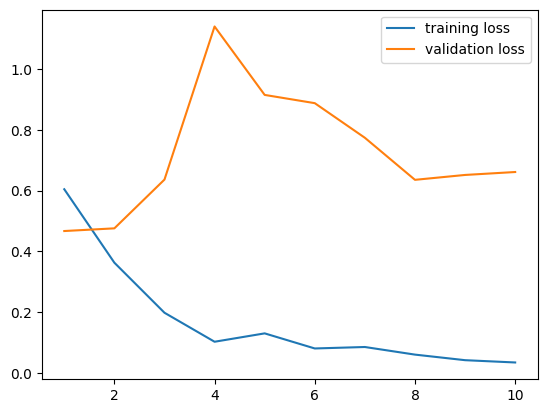

In [56]:
import matplotlib.pyplot as plt

x = [i+1 for i in range(num_epochs)]
y_t = np.array(train_loss) / len(train_dataloader)
y_v = np.array(valid_evaluation['loss'])/len(valid_dataloader)

plt.plot(x, y_t, label='training loss')
plt.plot(x, y_v, label='validation loss')
plt.legend()
plt.show()

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]